In [11]:
# This notebook marks an image as bad image if it has a descriptor
# far from the good images descriptors given a metric and a clustering 
# linkage method. By default it use metric=cosine and method=single
from azure.storage.blob import BlockBlobService, PublicAccess
import sys
sys.path.append('./')
#!pip install import-ipynb

In [12]:
# Take credential and access to azure blob storage
import config_blob_keys as cfg

account_name = cfg.AccountName
account_key = cfg.AccountKey

block_blob_service = BlockBlobService(account_name=account_name, account_key=account_key)

cont_name_analysis = cfg.ContNameAnalysis
block_blob_service.set_container_acl(cont_name_analysis, public_access=PublicAccess.Container)

cont_name_desc = cfg.ContNameDesc
block_blob_service.set_container_acl(cont_name_desc, public_access=PublicAccess.Container)

cont_name_desc_cor = cfg.ContNameDescCor
block_blob_service.set_container_acl(cont_name_desc_cor, public_access=PublicAccess.Container)

In [13]:
# Functions to work with azure blobs
def BlobList(container, folder, filelist, verbose=False):
    
    gen = block_blob_service.list_blobs(container, prefix=folder)
    
    for blob in gen:
        file = str(blob.name).replace(folder,'')
        filelist.append(file)
        if verbose == True:
            print("\t Blob name: " + blob.name)
        
    return filelist

# Download a file "blobfile" from "container" and save it 
# in the file "locfile"
def DownBlob(container, blobfile, locfile, verbose=False):
    
    if verbose == True:
        print('Downloading ' + blobfile + ' to ' + locfile)
    
    block_blob_service.get_blob_to_path(container, blobfile, locfile)

    if verbose == True:
        print('Downloading ' + blobfile + ' to ' + locfile)
    

# Uncompress data 
def UnCompress(file, verbose=False):
    
    if verbose == True:
        print('Uncompressing ' + file)
    
    subprocess.call(['uncompress', file])
    #os.popen('uncompress ' + file)

# Upload file "locfile" to the blob "blobfile" in container
def UpBlob(container, blobfile, locfile, verbose=False):
    
    if verbose == True:
        print('Uploading ' + locfile + ' to ' + blobfile)
        
    block_blob_service.create_blob_from_path(container, blobfile, locfile, validate_content=True)


In [14]:
# Funtions to visualize images maps and images histograms
def DisplayHist(imgood, imbad, verbose=False):

    im_data_g = np.load(imgood)
    im_mean_g = np.mean(im_data_g)
    im_median_g = np.median(im_data_g)
    im_std_g = np.std(im_data_g)
    
    im_data_b = np.load(imbad)
    im_mean_b = np.mean(im_data_b)
    im_median_b = np.median(im_data_b)
    im_std_b = np.std(im_data_b)
        
    im_median = 0.5*(im_median_g + im_median_b)
    im_mean = 0.5*(im_mean_g + im_mean_b)
    im_std = 0.5*(im_std_g + im_std_b)
    
    print("DMean: ", (im_mean_g-im_mean_b)/im_mean_g)
    print("DMedian: ", (im_median_g-im_median_b)/im_median_g)
    print("DStdDev: ", (im_std_g-im_std_b)/im_std_g)
        
    nbins = 100
    hist, bins, _ = plt.hist(np.ndarray.flatten(im_data_g), bins=nbins)
    plt.clf()
    #plt.figure(figsize=(10, 5))
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    fig, ax = plt.subplots(figsize=(8,4))
    plt.hist(np.ndarray.flatten(im_data_g), bins=logbins, range=[im_median/2, im_median*5], alpha=0.5, label = 'Good')
    plt.hist(np.ndarray.flatten(im_data_b), bins=logbins, range=[im_median/2, im_median*5], alpha=0.5, label = 'Bad')
    plt.legend()
    plt.title('Histogram')
    ax.set_yscale('log')
    plt.xscale('log')
    plt.xlabel('counts')
    plt.ylabel('# counts')
    plt.grid()
    plt.show()
    #fig.savefig(imnameb)
    
def DisplayMaps(imgood, imbad, verbose=False):
    
    im_data_g = np.load(imgood)
    im_mean_g = np.mean(im_data_g)
    im_median_g = np.median(im_data_g)
    im_std_g = np.std(im_data_g)
    
    im_data_b = np.load(imbad)
    im_mean_b = np.mean(im_data_b)
    im_median_b = np.median(im_data_b)
    im_std_b = np.std(im_data_b)
        
    im_median = 0.5*(im_median_g + im_median_b)    
    im_std = 0.5*(im_std_g + im_std_b)    
    
    fig, axrr = plt.subplots(1, 2, figsize=(10,12))
    #fig, ax = plt.subplots(figsize=(3,4))
    im = axrr[0].imshow(im_data_g, origin='lower', interpolation='nearest', vmin=im_median_g-im_std_g, vmax=im_median_g+2*im_std_g, cmap='Greys_r')
    axrr[0].set_title('Good')
    plt.tight_layout()
    axrr[0].set_xlabel('x')
    axrr[0].set_ylabel('y')

    #plt.subplot(1, 2, 2)
    #fig, ax = plt.subplots(figsize=(3,4))
    #fig, axrr = plt.subplots(1, 2, figsize=(16,8))
    im = axrr[1].imshow(im_data_b, origin='lower', interpolation='nearest', vmin=im_median_b-im_std_b, vmax=im_median_b+2*im_std_b, cmap='Greys_r')
    axrr[1].set_title('Bad')
    plt.tight_layout()
    axrr[1].set_xlabel('x')
    axrr[1].set_ylabel('y')
    
    plt.show()
    #fig.savefig(imnamea)

In [15]:
import pandas as pd
import numpy as np
#import utils_blob as ub
import os
import multiprocessing
import tqdm
import time
import random
import matplotlib.pyplot as plt
import warnings
from functools import partial

warnings.simplefilter("ignore")

In [16]:
# This cell list and download nsample descriptors from blob sotrage
# stored at method_dir
# The select_year flag allows selection of single year images
# For a given image type it take good and bad descriptors with its 
# correspondig abbreviation name
nsample = 20

method_dir = 'numpy/method3'

random.seed(101)
save_fig = False
select_year = False
year = '2018'

DescBlobSubDirs = ['UVES_BLUE_BIAS','UVES_RED_BIAS','UVES_BLUE_WAVE','UVES_DIC1B_FLAT','UVES_DIC1B_DFLAT','UVES_RED_WAVE','UVES_DIC1R_FLAT']
imag_dim = 11#len(DescBlobSubDirs)
desc_dim = 2048
samp_dim = nsample
cube_good = np.zeros((imag_dim,samp_dim,desc_dim))
cube_bad  = np.zeros((imag_dim,samp_dim,desc_dim))
cube      = np.zeros((imag_dim,samp_dim,desc_dim))
path_loc = '../Temp/test'
desc_name = []
desc_nameb = []
i = 0

print('Taking data from ',method_dir,'.')
# Loof for images type folder
for desc_blob_sub_dir in DescBlobSubDirs:
    
    # Images extensions    
    if desc_blob_sub_dir == 'UVES_BLUE_BIAS' or desc_blob_sub_dir == 'UVES_DIC1B_FLAT' or desc_blob_sub_dir == 'UVES_DIC1B_DFLAT':
        Exten = [0]
    elif desc_blob_sub_dir == 'UVES_RED_BIAS' or desc_blob_sub_dir == 'UVES_BLUE_WAVE' or desc_blob_sub_dir == 'UVES_RED_WAVE' or desc_blob_sub_dir == 'UVES_DIC1R_FLAT':
        Exten = [1,2]
    
    # Define the image type
    if desc_blob_sub_dir == 'UVES_BLUE_BIAS':
        image_type = 'bias_blue'
        abr_name = 'UBB'
    elif desc_blob_sub_dir == 'UVES_RED_BIAS':
        image_type = 'URB'
    elif desc_blob_sub_dir == 'UVES_BLUE_WAVE' or desc_blob_sub_dir == 'UVES_DIC1B_FLAT' or desc_blob_sub_dir == 'UVES_DIC1B_DFLAT':
        image_type = 'blue_arc_flat'
        if desc_blob_sub_dir == 'UVES_BLUE_WAVE':
            abr_name = 'UBW'
        elif desc_blob_sub_dir == 'UVES_DIC1B_FLAT':
            abr_name = 'UD1BF'
        elif desc_blob_sub_dir == 'UVES_DIC1B_DFLAT':
            abr_name = 'UD1BDF'
    elif desc_blob_sub_dir == 'UVES_RED_WAVE' or desc_blob_sub_dir == 'UVES_DIC1R_FLAT':
        image_type = 'red_arc_flat'
        if desc_blob_sub_dir == 'UVES_RED_WAVE':
            abr_name = 'URW'
        elif desc_blob_sub_dir == 'UVES_DIC1R_FLAT':
            abr_name = 'UD1RF'

    # Take bad image names
    PROJECT_DIR = "/data/notebooks/uves_jprieto"
    DATA_DIR = os.path.join(PROJECT_DIR, "data")
    
    uves_flag_file=os.path.join(DATA_DIR, 'UVES_hidden_flag_results.txt')
    uves_flag_df=pd.read_csv(uves_flag_file, comment='#', sep=';')
    corrupted_df = uves_flag_df[(uves_flag_df['image_type'] == image_type) & (uves_flag_df['flag'] == 'CORRUPTED')]
    bad_files_garchim = list(corrupted_df['filename']) 
    
    # Loop for images extensions
    for ext in Exten:
        abr_name = abr_name + str(ext)
        extension = 'ext'+str(ext)
        print('Working on ' + desc_blob_sub_dir + ' extension ' + extension + '...\n')
        
        # Bad Garchim images
        # ----------------------------------------------------------------------
        desc_folder_rem = os.path.join(method_dir,desc_blob_sub_dir)
        desc_folder_rem = os.path.join(desc_folder_rem,extension)
        
        desc_files_list = []
        BlobList(cont_name_desc, desc_folder_rem, desc_files_list)
        
        desc_cor_list = []
        desc_files_list = [s for s in desc_files_list if any(xs in s for xs in bad_files_garchim)]
        
        if len(desc_files_list) >= nsample:
            desc_files_list = random.sample(desc_files_list, nsample)
        desc_badg_files = desc_files_list


        # Good images method
        # ----------------------------------------------------------------------
        desc_folder_rem = os.path.join(method_dir,desc_blob_sub_dir)
        desc_folder_rem = os.path.join(desc_folder_rem,extension)
        
        desc_files_list = []
        BlobList(cont_name_desc, desc_folder_rem, desc_files_list)
        
        desc_files_list = [s for s in desc_files_list if s not in bad_files_garchim]
        if select_year==True:
            desc_files_list = [s for s in desc_files_list if year in s]
            if len(desc_files_list) >= nsample:
                desc_files_list = random.sample(desc_files_list, nsample)
        elif select_year==False:
            if len(desc_files_list) >= nsample:
                desc_files_list = random.sample(desc_files_list, nsample)        
        desc_good_files = desc_files_list
        
        desc_temp = np.zeros(2048).T
        desc_matrix = np.expand_dims(desc_temp,axis=0)

        im_abr = []
        print('Good images...')
        with tqdm.tqdm_notebook(total=len(desc_files_list)) as pbar:
            for idx in range(len(desc_files_list)):
                
                name = abr_name + str(idx)
                im_abr.append(name)
                file = desc_files_list[idx]
                desc_blob_name = desc_folder_rem + file
                descriptor_file = path_loc + file

                DownBlob(cont_name_desc, desc_blob_name, descriptor_file, False)
                
                while not os.path.exists(descriptor_file):
                    time.sleep(0.1)

                desc_resNet50 = np.load(descriptor_file)
                np_desc = np.array(desc_resNet50)
                desc_matrix = np.vstack((desc_matrix,np_desc))
                os.remove(descriptor_file)
                pbar.update(1)
        
        desc_name.append(im_abr)
        desc_good = np.delete(desc_matrix,0,axis=0)
        cube_good[i,:,:] = desc_good 
        
        # Bad Nicolas images
        # ----------------------------------------------------------------------
        desc_folder_rem = os.path.join(method_dir,desc_blob_sub_dir)
        desc_folder_rem = os.path.join(desc_folder_rem,extension)
        
        desc_files_list = []
        BlobList(cont_name_desc_cor, desc_folder_rem, desc_files_list)
        if nsample<=100:
            desc_files_list = random.sample(desc_files_list, nsample)
        desc_badn_files = desc_files_list
        desc_temp = np.zeros(2048).T
        desc_matrix = np.expand_dims(desc_temp,axis=0)
        
        im_abr = []
        print('Bad Nicolas images...')
        with tqdm.tqdm_notebook(total=len(desc_files_list)) as pbar:
            for idx in range(len(desc_files_list)):
                
                name = abr_name + str(idx) + '_b'
                im_abr.append(name)
                
                file = desc_files_list[idx]
                desc_blob_name = desc_folder_rem + file
                descriptor_file = path_loc + file
                
                DownBlob(cont_name_desc_cor, desc_blob_name, descriptor_file, False)

                while not os.path.exists(descriptor_file):
                    time.sleep(0.1)
                    
                desc_resNet50 = np.load(descriptor_file)
                np_desc = np.array(desc_resNet50)
                desc_matrix = np.vstack((desc_matrix,np_desc))
                os.remove(descriptor_file)
                pbar.update(1)
        
        desc_nameb.append(im_abr)
        desc_badn = np.delete(desc_matrix,0,axis=0)
        cube_bad[i,:,:] = desc_badn
        i+=1

Taking data from  numpy/method3 .
Working on UVES_BLUE_BIAS extension ext0...

Good images...



Bad Nicolas images...



Working on UVES_RED_BIAS extension ext1...

Good images...



Bad Nicolas images...



Working on UVES_RED_BIAS extension ext2...

Good images...



Bad Nicolas images...



Working on UVES_BLUE_WAVE extension ext1...

Good images...



Bad Nicolas images...



Working on UVES_BLUE_WAVE extension ext2...

Good images...



Bad Nicolas images...



Working on UVES_DIC1B_FLAT extension ext0...

Good images...



Bad Nicolas images...



Working on UVES_DIC1B_DFLAT extension ext0...

Good images...



Bad Nicolas images...



Working on UVES_RED_WAVE extension ext1...

Good images...



Bad Nicolas images...



Working on UVES_RED_WAVE extension ext2...

Good images...



Bad Nicolas images...



Working on UVES_DIC1R_FLAT extension ext1...

Good images...



Bad Nicolas images...



Working on UVES_DIC1R_FLAT extension ext2...

Good images...



Bad Nicolas images...


In [17]:
# It define the clustering parameters
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

norm = False
method = 'single'
metric = 'cosine'
criterion = 'distance'

In [18]:
# Save descriptors and names for each image
UBB0    = cube_good[ 0,:,:]
URB1    = cube_good[ 1,:,:]
URB2    = cube_good[ 2,:,:]
UBW1    = cube_good[ 3,:,:]
UBW2    = cube_good[ 4,:,:]
UD1BF0  = cube_good[ 5,:,:]
UD1BDF0 = cube_good[ 6,:,:]
URW1    = cube_good[ 7,:,:]
URW2    = cube_good[ 8,:,:]
UD1RF1  = cube_good[ 9,:,:]
UD1RF2  = cube_good[10,:,:]

UBB0name    = desc_name[ 0]
URB1name    = desc_name[ 1]
URB2name    = desc_name[ 2]
UBW1name    = desc_name[ 3]
UBW2name    = desc_name[ 4]
UD1BF0name  = desc_name[ 5]
UD1BDF0name = desc_name[ 6]
URW1name    = desc_name[ 7]
URW2name    = desc_name[ 8]
UD1RF1name  = desc_name[ 9]
UD1RF2name  = desc_name[10]

UBB0b    = cube_bad[ 0,:,:]
URB1b    = cube_bad[ 1,:,:]
URB2b    = cube_bad[ 2,:,:]
UBW1b    = cube_bad[ 3,:,:]
UBW2b    = cube_bad[ 4,:,:]
UD1BF0b  = cube_bad[ 5,:,:]
UD1BDF0b = cube_bad[ 6,:,:]
URW1b    = cube_bad[ 7,:,:]
URW2b    = cube_bad[ 8,:,:]
UD1RF1b  = cube_bad[ 9,:,:]
UD1RF2b  = cube_bad[10,:,:]

UBB0nameb    = desc_nameb[ 0]
URB1nameb    = desc_nameb[ 1]
URB2nameb    = desc_nameb[ 2]
UBW1nameb    = desc_nameb[ 3]
UBW2nameb    = desc_nameb[ 4]
UD1BF0nameb  = desc_nameb[ 5]
UD1BDF0nameb = desc_nameb[ 6]
URW1nameb    = desc_nameb[ 7]
URW2nameb    = desc_nameb[ 8]
UD1RF1nameb  = desc_nameb[ 9]
UD1RF2nameb  = desc_nameb[10]

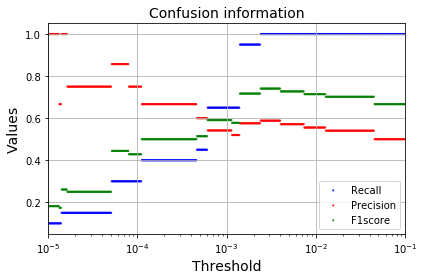

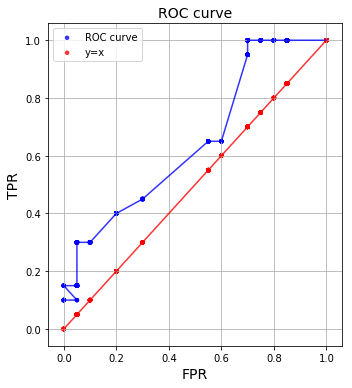

Threshold      : 0.00240
F score (F1)   : 0.74074
Recall (TPR)   : 1.00000
Precision (PPV): 0.58824


In [19]:
# Loop to look for the optimus threshold in order to cluster
# the good and bad images
# The images name abbreviation are
# UBB0,URB1,URB2,UBW1,UBW2,UD1BF0,UD1BDF0,URW1,URW2,UD1RF1,UD1RF2
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from sklearn.metrics import accuracy_score
from statistics import mode
from scipy.cluster.vq import whiten

np.set_printoptions(precision=6, suppress=True)

def most_frequent(List): 
    return max(set(List), key = List.count) 

im_name = 'URW2'
matg = URW2
matb = URW2b
mat  = np.vstack((matg,matb))

if norm==True:
    mat = whiten(mat)

namesg = UD1BF0name
namesb = UD1BF0nameb
names = namesg
names.extend(namesb)

rate = []
ratef = []
rateg = []
rateb = []
fscore = []
threshold = []

threshi = 1.0e-5
threshe = 1.0e-1
thresh_list = list(np.geomspace(threshi,threshe,num=500))

with tqdm.tqdm_notebook(total=len(thresh_list)) as pbar:
    for thresh in thresh_list:
        model = AgglomerativeClustering(n_clusters=None, 
                                          affinity=metric, 
                                          linkage=method,
                                          distance_threshold=thresh, 
                                          compute_full_tree=True)  
        clusters = model.fit(mat)
        labels = clusters.labels_
        arrg = labels[:nsample]
        arrb = labels[nsample:]
        listg = list(arrg)
        listb = list(arrb)
        val = most_frequent(listg)
        tp = listg.count(val)
        fp = listb.count(val)
        tn = len(listb)-fp
        fn = len(listg)-tp
        # Compute "by hand" the statistical values
        TPR = tp/max(tp+fn,1.0e-5) # recall (true positive rate)
        FPR = fp/max(fp+tn,1.0e-5) # false positve rate
        PPV = tp/max(tp+fp,1.0e-5) # precision
        NPV = tn/max(tn+fn,1.0e-5) # negative predicted value
        F1 = 2.0*PPV*TPR/max(PPV+TPR,1.0e-5)
        #print(thresh,PPV)
        rate.append(TPR)
        ratef.append(FPR)
        rateg.append(PPV)
        rateb.append(NPV)
        fscore.append(F1)
        threshold.append(thresh)
        pbar.update(1)

x = threshold
y = rate
z = rateg
k = fscore

plt.scatter(x, y, c='blue', s=5, alpha=0.8, edgecolors='none', label='Recall')
plt.scatter(x, z, c='red', s=5, alpha=0.8, edgecolors='none', label='Precision')
plt.scatter(x, k, c='green', s=5, alpha=0.8, edgecolors='none', label='F1score')
plt.legend()
plt.title('Confusion information', fontsize=14)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.xscale('log')
plt.xlim((threshi,threshe))
plt.tight_layout()
plt.grid()
plt.show()
if save_fig==True:
    plt.savefig('./figure.png')

max_fscore = max(fscore)
ind_list = [i for i, j in enumerate(fscore) if j == max_fscore]
ind = ind_list[0]
max_thresh = thresh_list[ind]
max_rate = rate[ind]
max_rateg = rateg[ind]
threshc = max_thresh

x = ratef
y = rate
fig = plt.figure(figsize=(5,5.5))
plt.scatter(x, y, c='blue', s=20, alpha=0.8, edgecolors='none', label='ROC curve')
plt.plot(x, y, c='blue', alpha=0.8, label=None)
plt.scatter(x, x, c='red', s=20, alpha=0.8, edgecolors='none', label='y=x')
plt.plot(x, x, c='red', alpha=0.8, label=None)
plt.legend()
plt.title('ROC curve', fontsize=14)
plt.xlabel('FPR', fontsize=14)
plt.ylabel('TPR', fontsize=14)
plt.tight_layout()
plt.grid()
plt.show()

print('Threshold      : %.5f' % max_thresh)
print('F score (F1)   : %.5f' % max_fscore)
print('Recall (TPR)   : %.5f' % max_rate)
print('Precision (PPV): %.5f' % max_rateg)

#plt.scatter(clusters[0,0],clusters[0,1], s=10, c='red', alpha=0.8, label='Cluster 1')
#plt.scatter(clusters[1,0],clusters[1,1], s=10, c='blue', alpha=0.8, label='Cluster 2')
#plt.show()

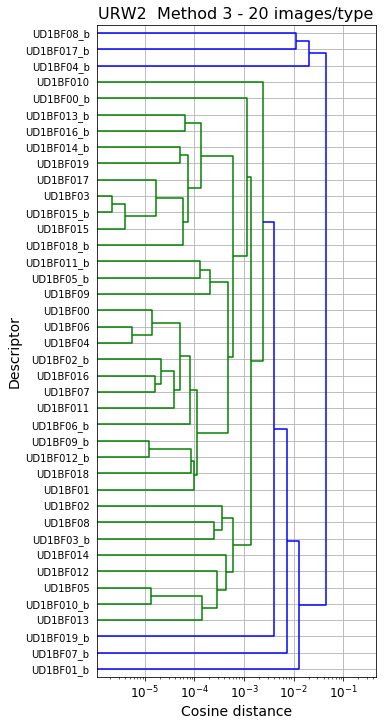

In [20]:
# For the parameters defined above create the desdrograms
# of the clustering process
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

thresh = threshc
fig = plt.figure(figsize=(5,12))
plt.title('%s  Method 3 - %i images/type' % (im_name, nsample), fontsize=16)

Z = sch.linkage(mat, method=method, metric=metric, optimal_ordering=True)
ymax = 10.0*Z[mat.shape[0]-2,2]
ymin = 0.5*Z[0,2]
dend = sch.dendrogram(Z, color_threshold=threshc, labels=names, orientation='right')
plt.ylabel('Descriptor', fontsize=14)
plt.xlabel('Cosine distance', fontsize=14)
plt.xscale('log')
plt.yticks(fontsize=10)
plt.xticks(fontsize=12)
plt.xlim((ymin,ymax))
plt.grid()
plt.show()

if save_image==True:
    fig.savefig('figure.png')